# Multivariate target gaussian

- Create a 2d target
- Plot it to see if it's correct
- Write up a MCMC sampler

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
def cr_multivar_gaussian(mu1, sig1, mu2, sig2, cov12):
    means = np.array([mu1, mu2])
    cov_matrix = np.array([[sig1**2, cov12],
                            [cov12, sig2**2]])
    mvn = multivariate_normal(mean=means, cov=cov_matrix)
    return mvn

In [3]:
def swelling_perc(fd):
    return 6.13e-43 * fd**2 + 4e-21 * fd

In [4]:
mu1 = swelling_perc(1e21)
mu2 = swelling_perc(7e21)
sig = 2.7
print(mu1-sig, mu1, mu1+sig)
print(mu2-sig, mu2, mu2+sig)

1.9129999999999994 4.6129999999999995 7.313
55.336999999999996 58.037 60.737


In [5]:
cov12 = 0
mvn = cr_multivar_gaussian(mu1, sig, mu2, sig, cov12)

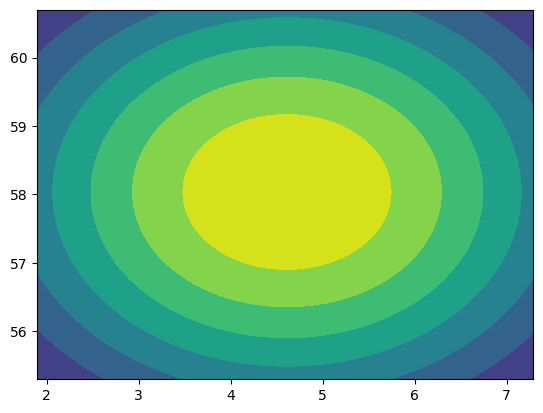

In [6]:
x, y = np.mgrid[1.9:7.3:0.01, 55.3:60.7:0.01]
pos = np.dstack((x, y))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x, y, mvn.pdf(pos))
plt.show()

# Data loading

In [7]:
jar = pd.read_csv('clean_data.csv')

In [8]:
fdVals = jar['FD'].unique()
low_fd = fdVals[0]
high_fd = fdVals[-1]

In [9]:
lo_data = jar[jar['FD'] == low_fd]
hi_data = jar[jar['FD'] == high_fd]

# Lasso

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [11]:
feat_ind = list(range(7))
features = lo_data.iloc[:, feat_ind]
xscaler = StandardScaler()
X = xscaler.fit_transform(features)

In [12]:
y1 = lo_data['fuel_swelling']
y2 = hi_data['fuel_swelling']

In [13]:
reg1 = linear_model.Lasso(alpha=0.0001)
reg2 = linear_model.Lasso(alpha=0.05)

In [14]:
reg1.fit(X, y1)
reg2.fit(X, y2)

Lasso(alpha=0.05)

In [15]:
print(reg1.score(X, y1),
      reg2.score(X, y2))

0.9971307446714307 0.9969293137300165


In [16]:
print(reg1.coef_,
      reg2.coef_)

[-0.         -0.          0.         -0.01869087  0.005785   -0.00582711
  0.02142958] [ 4.03026403 -2.45628912 -0.46216236 -0.          0.          0.
  0.        ]


# MCMC sampler

In [17]:
def candidate_dist(x, sig):
    return np.random.normal(x, sig)

In [18]:
def mcmc_sampler(num_param, initial_state, proposal_sig,
                 surrogates, target_mvn, num_samples):
    samples = [initial_state]

    for ii in range(num_samples):
        current_state = samples[-1]

        for jj in range(num_param):
            current_p = current_state[jj]
            proposed_p = 6
            while (abs(proposed_p) > 3):
                proposed_p = candidate_dist(current_p, proposal_sig)

            proposed_state = copy.deepcopy(current_state)
            proposed_state[jj] = proposed_p

            fs1_curr = surrogates[0].predict([[*current_state]])[0]
            fs2_curr = surrogates[1].predict([[*current_state]])[0]
            
            fs1_prop = surrogates[0].predict([[*proposed_state]])[0]
            fs2_prop = surrogates[1].predict([[*proposed_state]])[0]

            acceptance_ratio = target_mvn.pdf([fs1_prop, fs2_prop]) / target_mvn.pdf([fs1_curr, fs2_curr])

            if np.random.rand() < acceptance_ratio:
                current_state = proposed_state

            # Why not append param set after a single change?
            samples.append(current_state)
        #samples.append(current_state)
        
    return np.array(samples)

In [26]:
hey = mcmc_sampler(7, np.zeros(7), 0.2, [reg1, reg2], mvn, 10000)

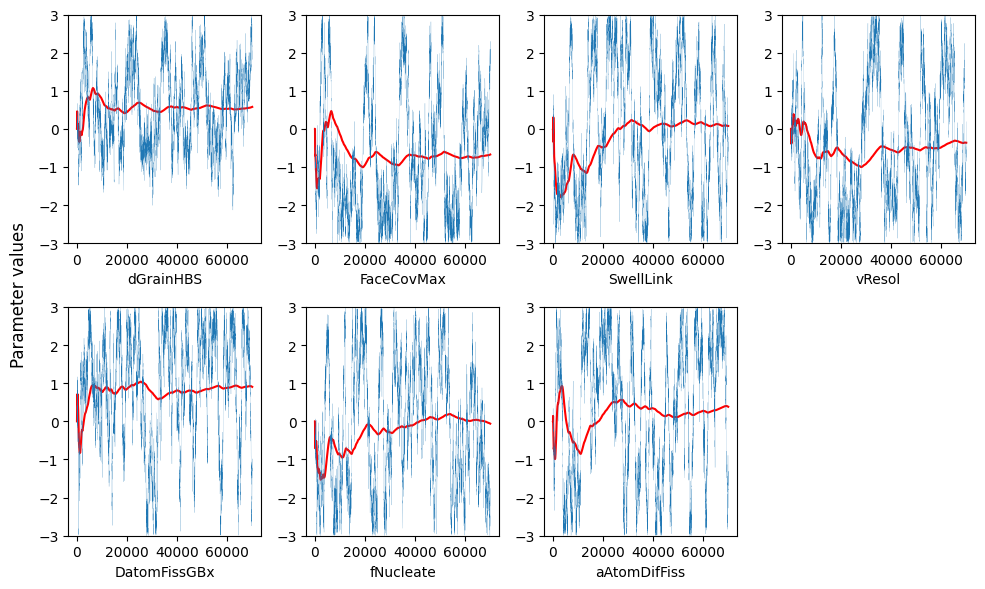

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    cdat = hey[:,i]
    cavg = np.cumsum(cdat) / np.arange(1, len(cdat)+1)
    ax.plot(cavg, c='r')
    ax.plot(cdat, lw=0.1)
    ax.set_xlabel(lo_data.columns[i])
    ax.set_ylim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

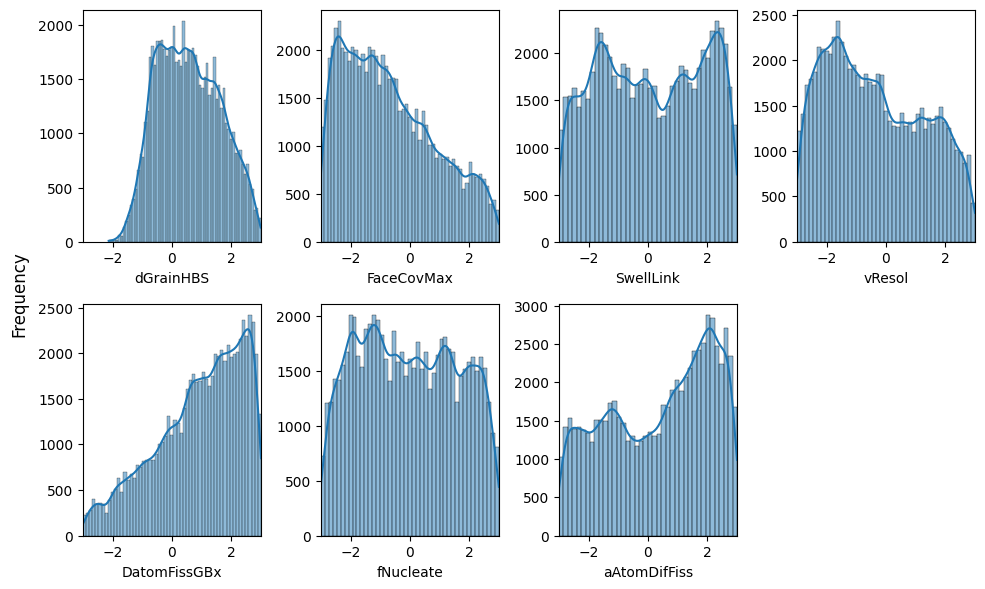

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(hey[:,i], ax=ax, kde=True)
    ax.set_xlabel(lo_data.columns[i])
    ax.set_ylabel('')
    ax.set_xlim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Frequency')
plt.tight_layout()
plt.show()

# Forward propagation

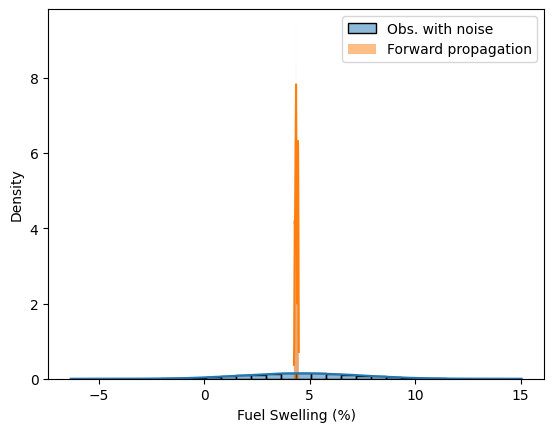

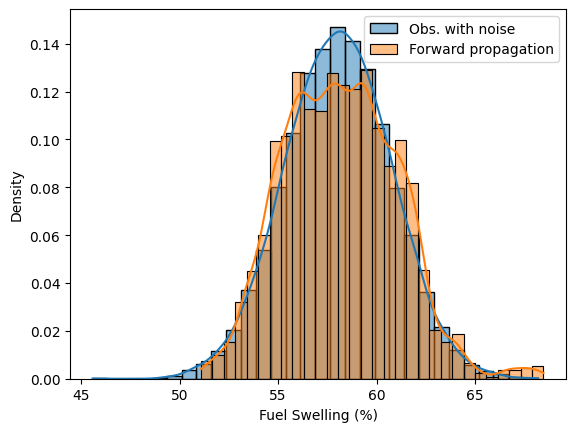

In [29]:
mus = [mu1, mu2]
sigs = [sig, sig]

for mod, mu, sig in zip([reg1, reg2], mus, sigs):
    orig = []
    res = []
    for i in range(10000):
        res.append(mod.predict([hey[-i]])[0])
        c = np.random.normal(mu, sig)
        orig.append(c)
        
    sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
    sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')
    
    plt.xlabel('Fuel Swelling (%)')
    plt.legend()
    plt.show()